In [3]:
import yaml
from pydub import AudioSegment
import numpy as np
import wave
import os
import numpy as np
import soundfile as sf
from scipy.ddsignal import stft
import matplotlib.pyplot as plt
from tqdm import tqdm

  0%|          | 0/20 [00:00<?, ?it/s]

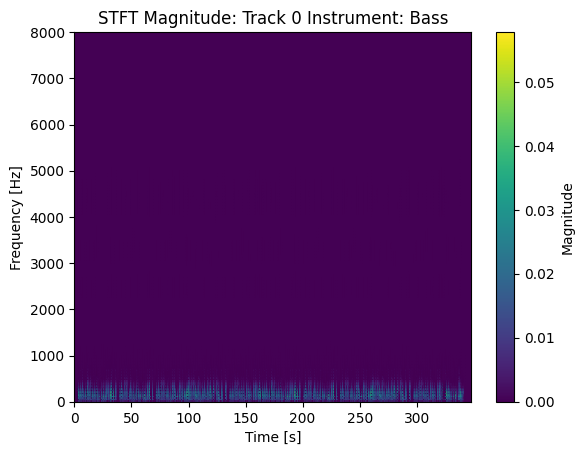

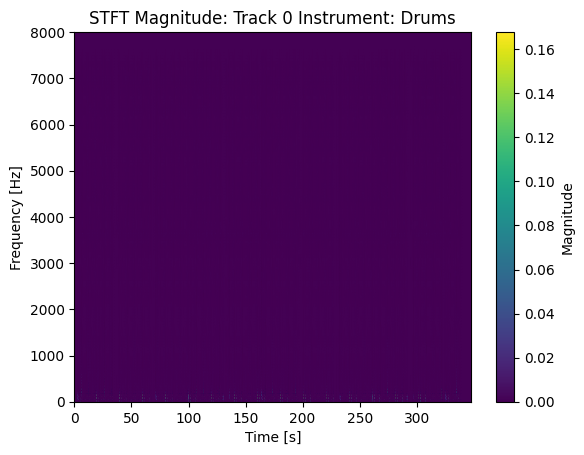

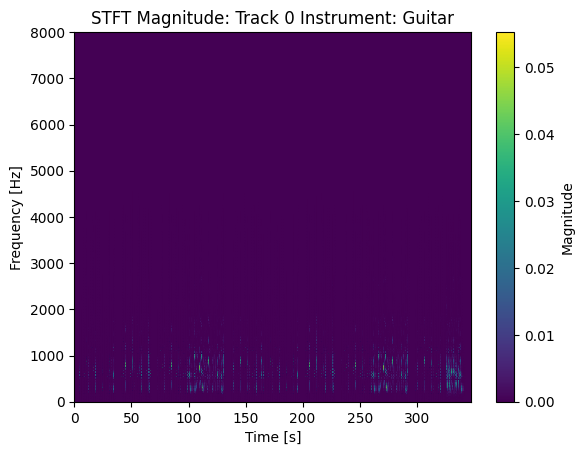

  5%|▌         | 1/20 [00:32<10:25, 32.93s/it]

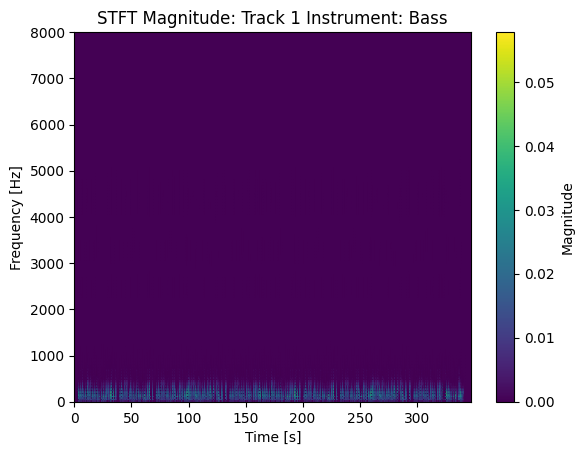

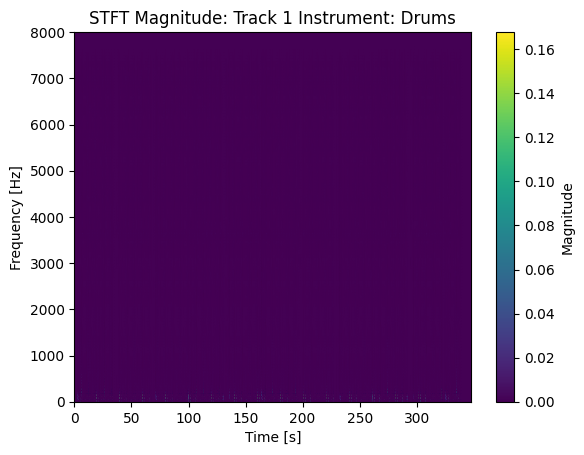

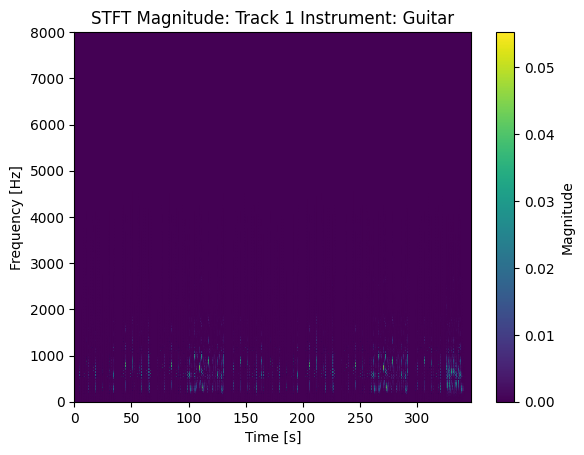

 10%|█         | 2/20 [01:05<09:54, 33.00s/it]

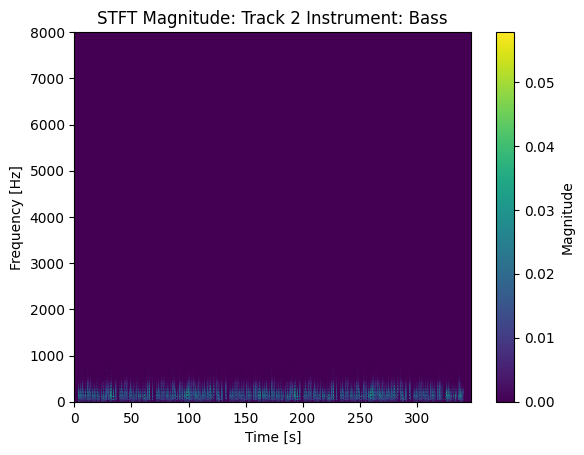

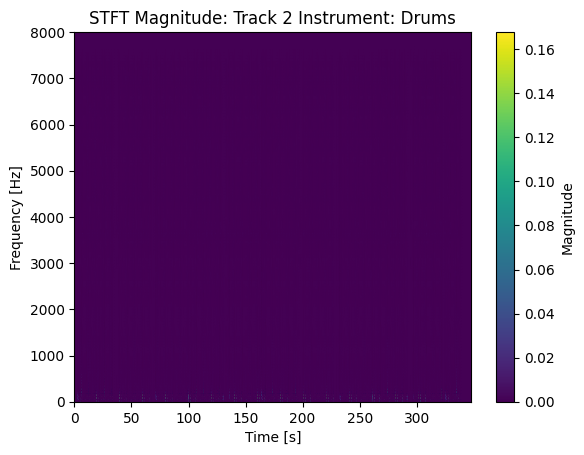

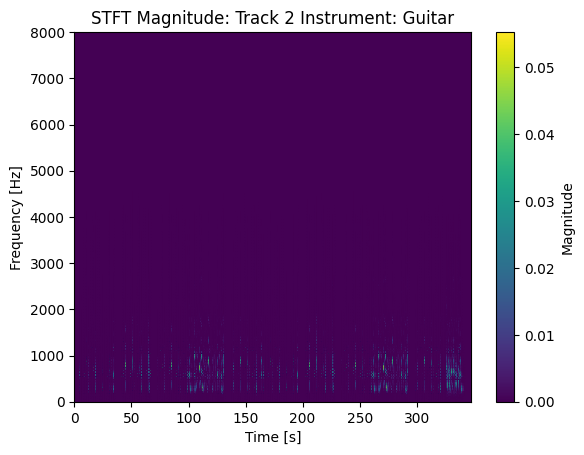

 15%|█▌        | 3/20 [01:38<09:18, 32.82s/it]

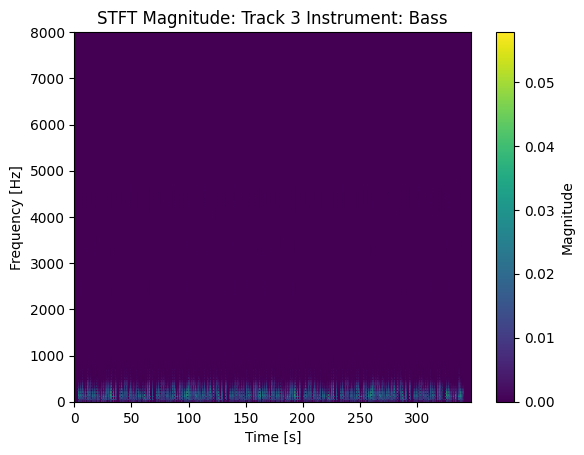

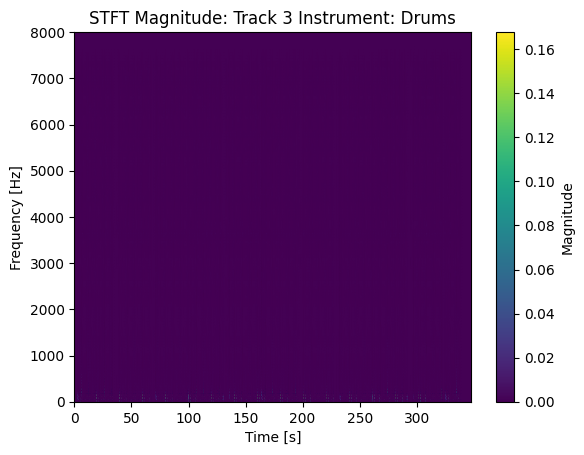

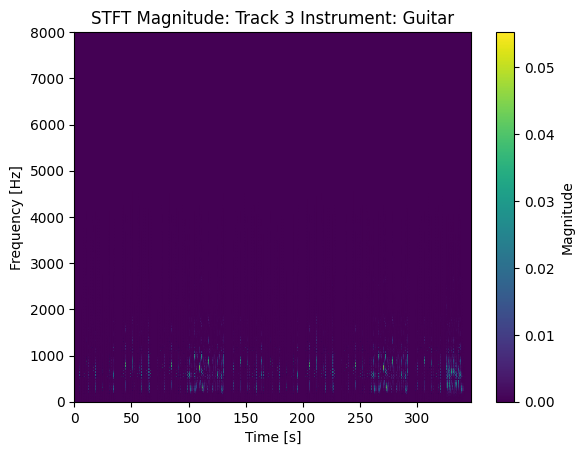

 20%|██        | 4/20 [02:11<08:44, 32.75s/it]

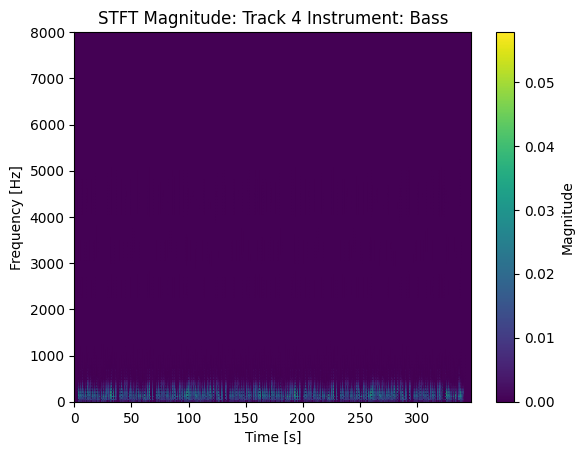

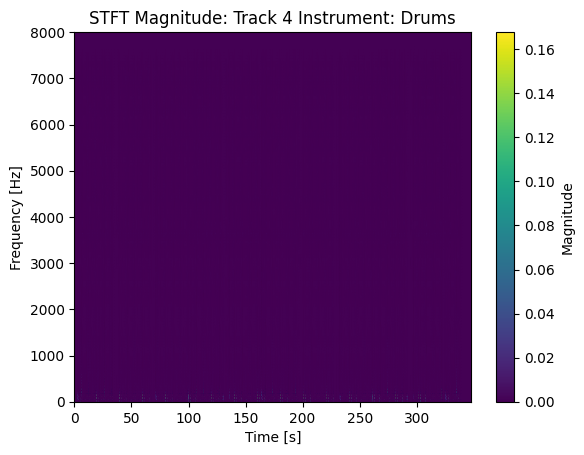

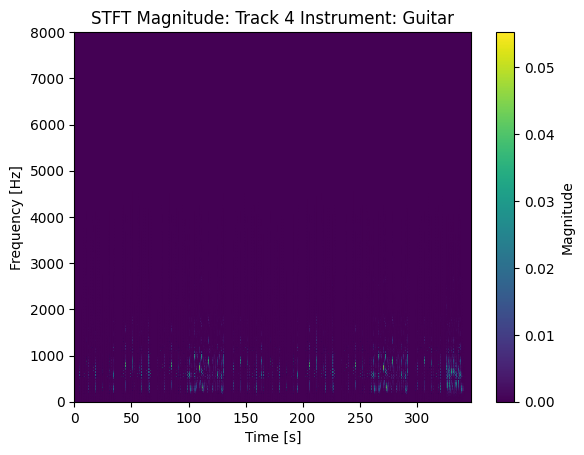

 25%|██▌       | 5/20 [02:44<08:11, 32.76s/it]

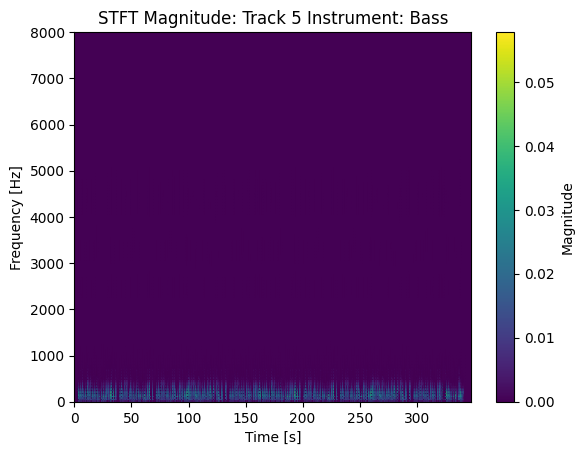

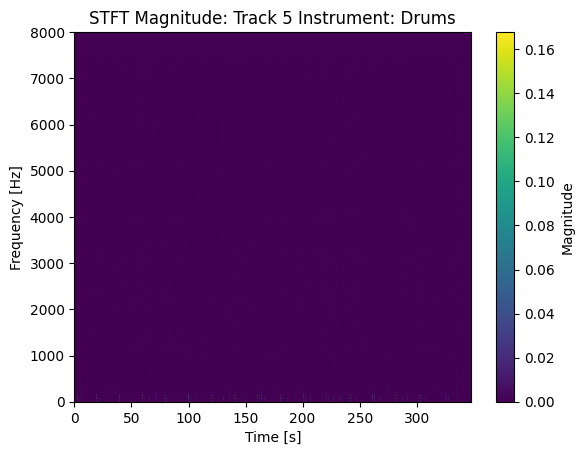

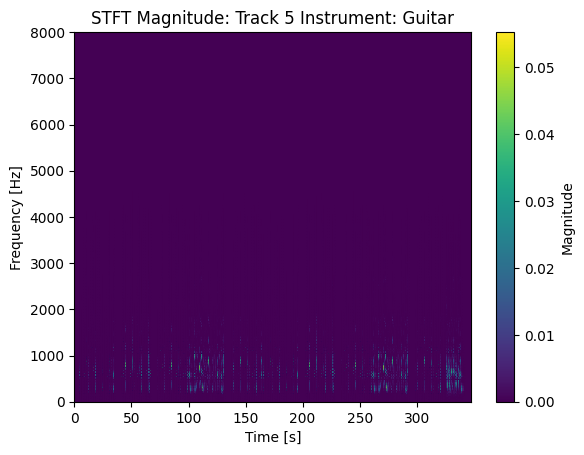

 30%|███       | 6/20 [03:16<07:38, 32.73s/it]

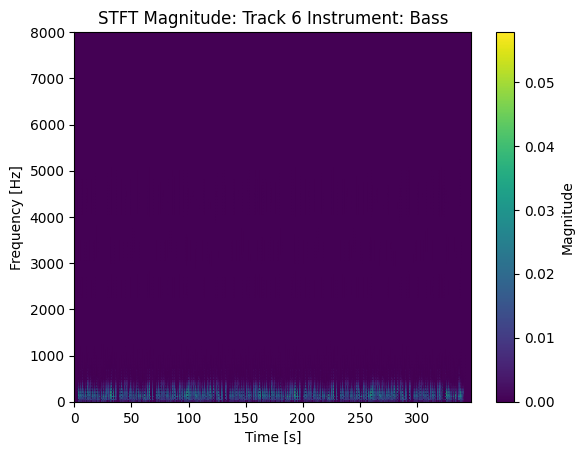

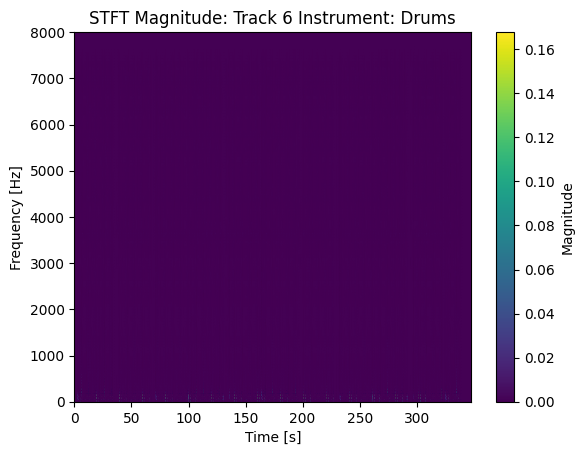

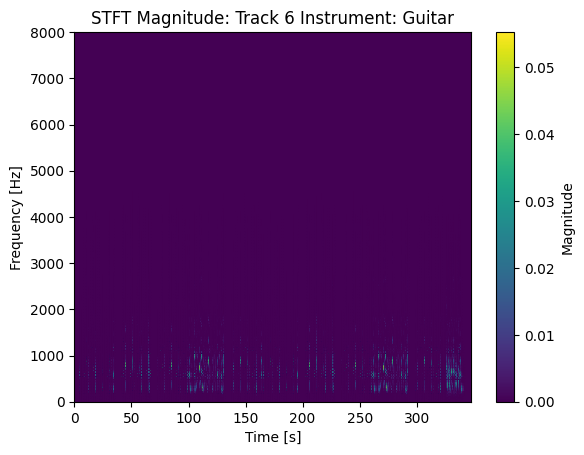

 35%|███▌      | 7/20 [03:49<07:05, 32.72s/it]

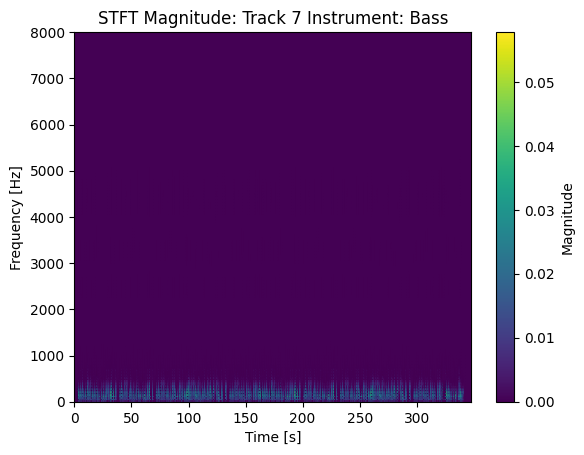

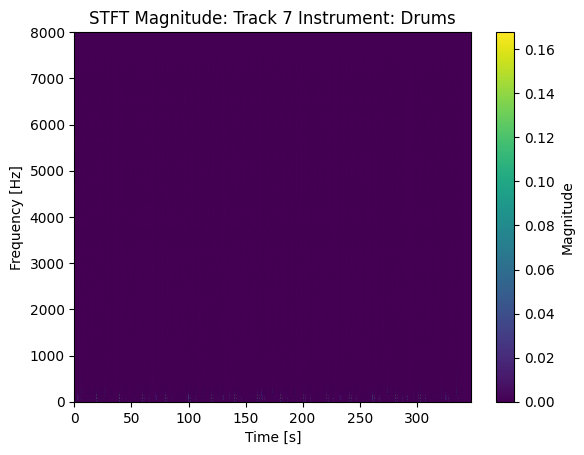

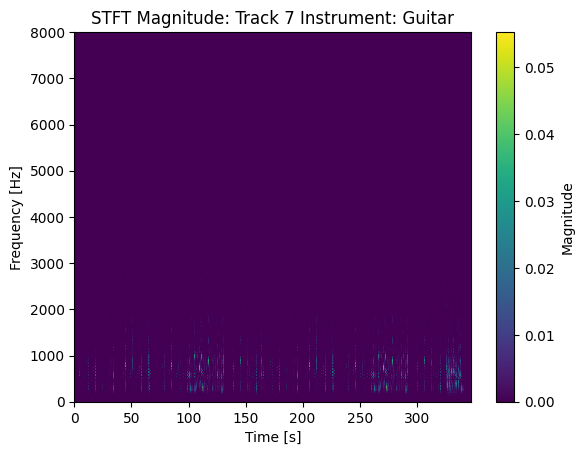

 40%|████      | 8/20 [04:22<06:35, 32.97s/it]

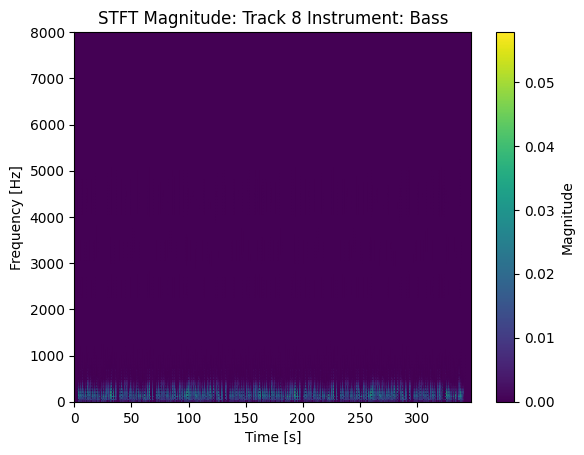

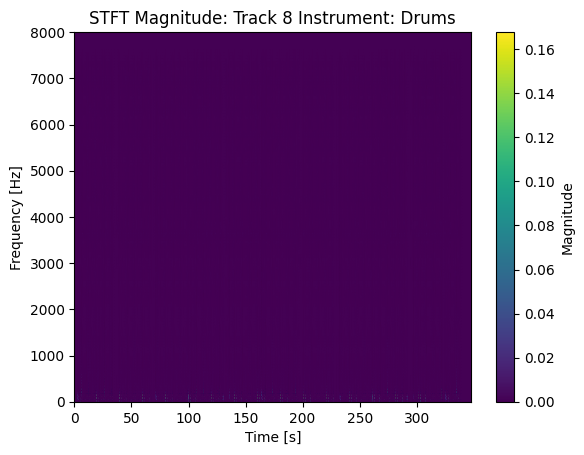

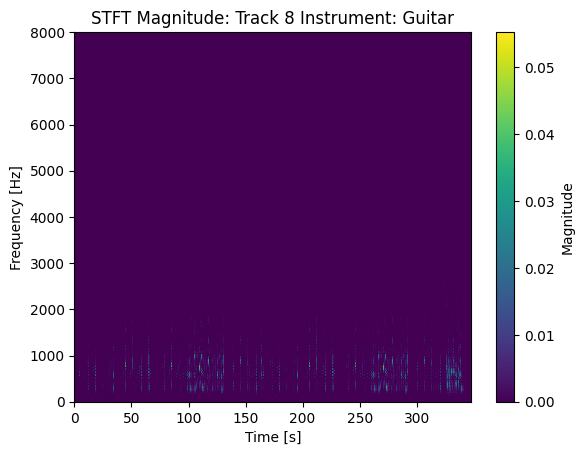

 45%|████▌     | 9/20 [04:55<06:02, 32.93s/it]

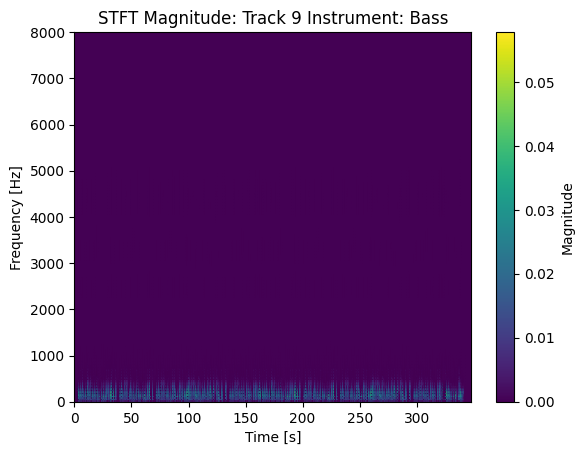

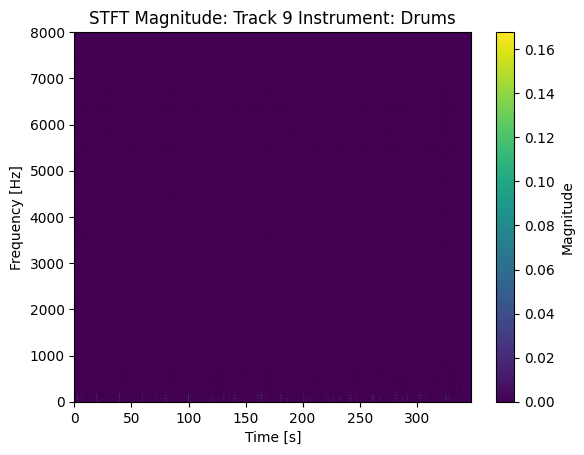

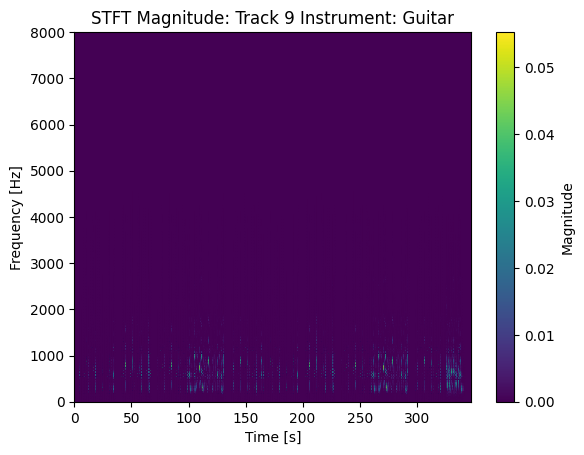

 50%|█████     | 10/20 [05:28<05:29, 32.92s/it]

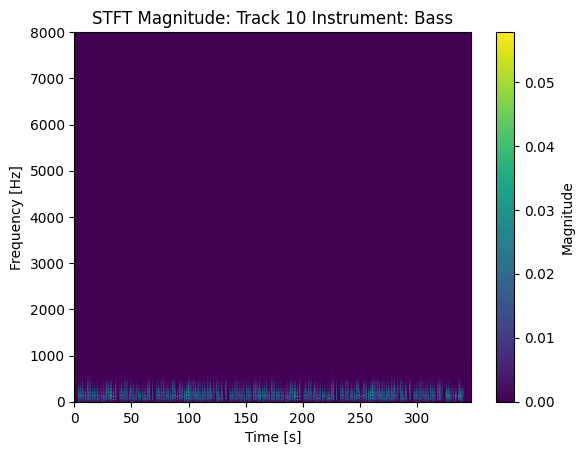

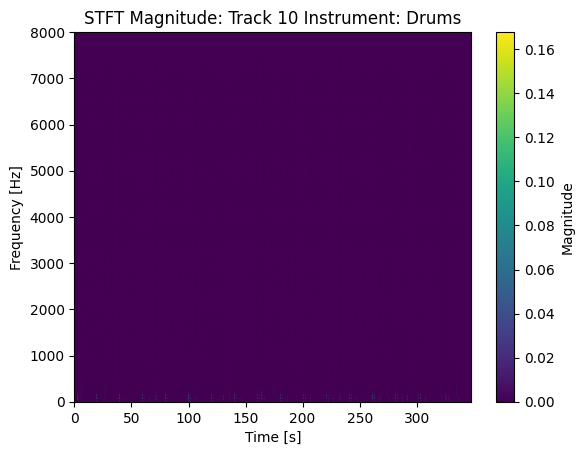

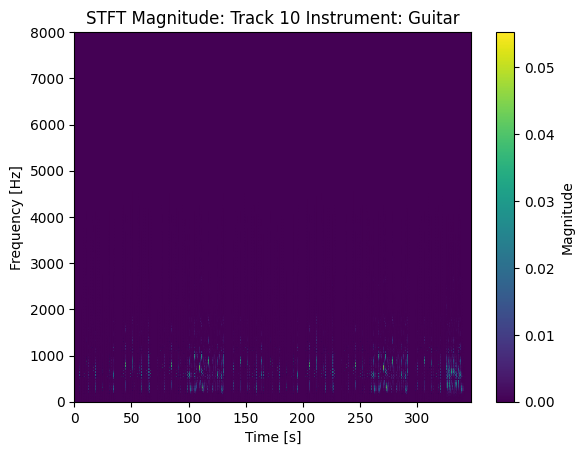

 55%|█████▌    | 11/20 [06:01<04:56, 32.95s/it]

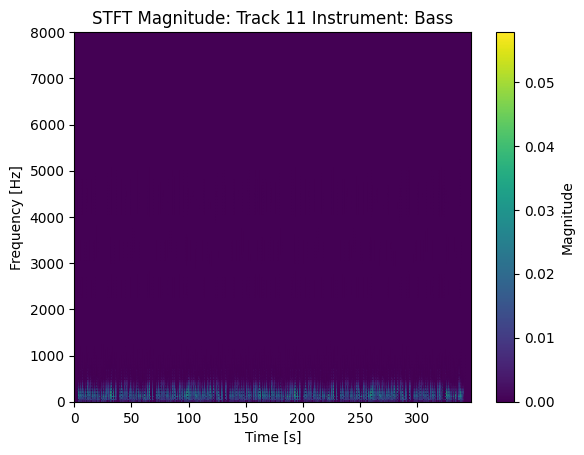

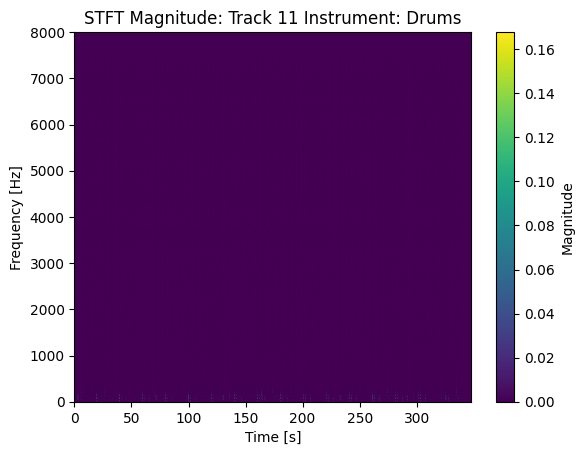

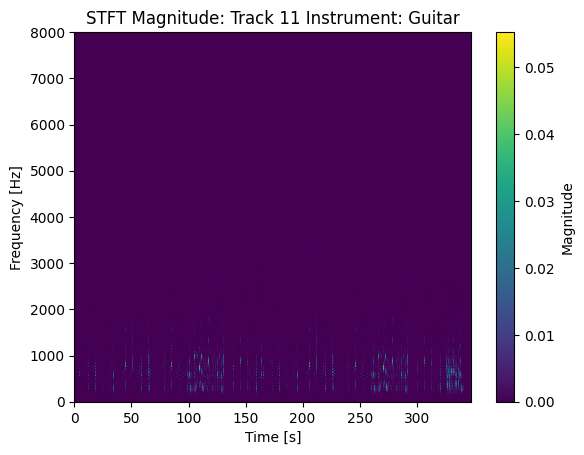

 60%|██████    | 12/20 [06:34<04:23, 32.97s/it]

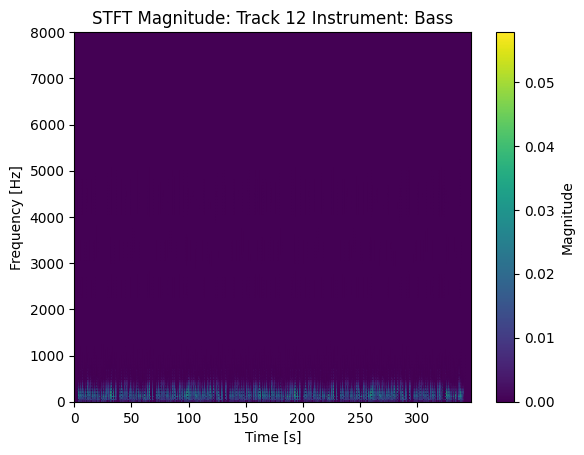

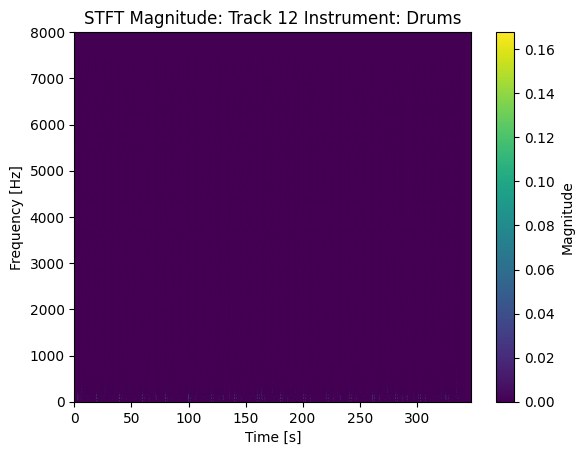

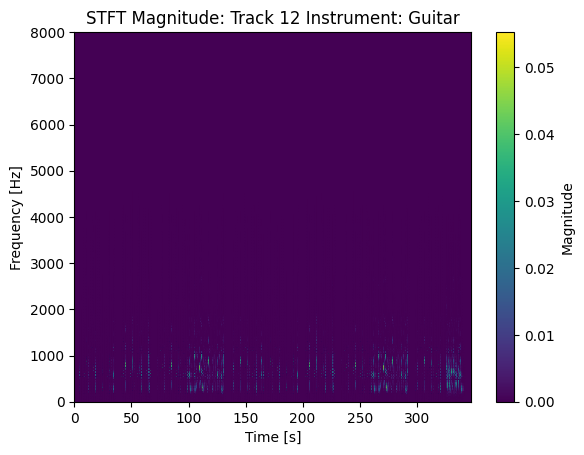

 65%|██████▌   | 13/20 [07:08<03:51, 33.08s/it]

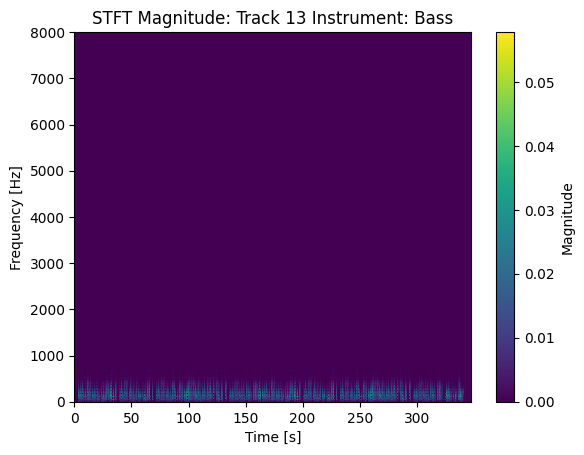

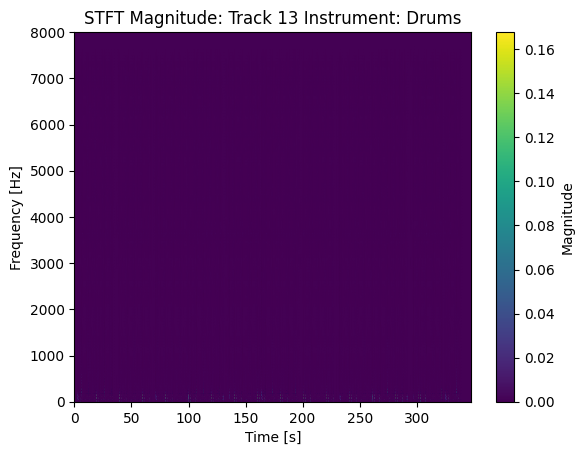

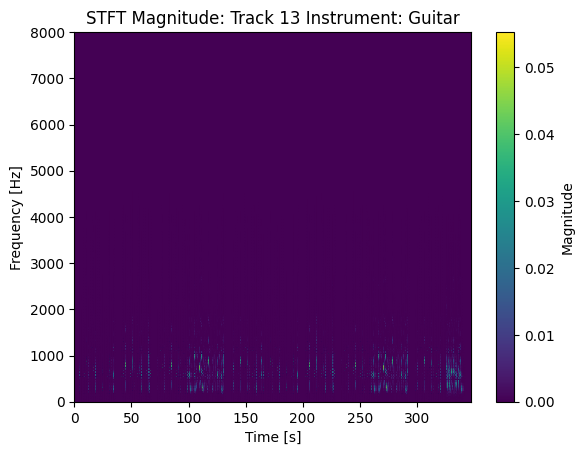

 70%|███████   | 14/20 [07:40<03:18, 33.03s/it]

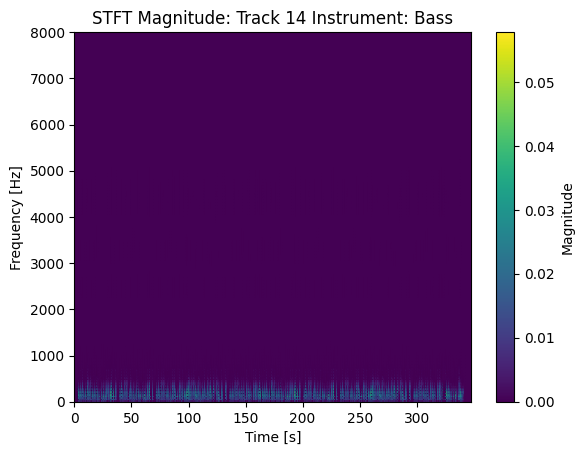

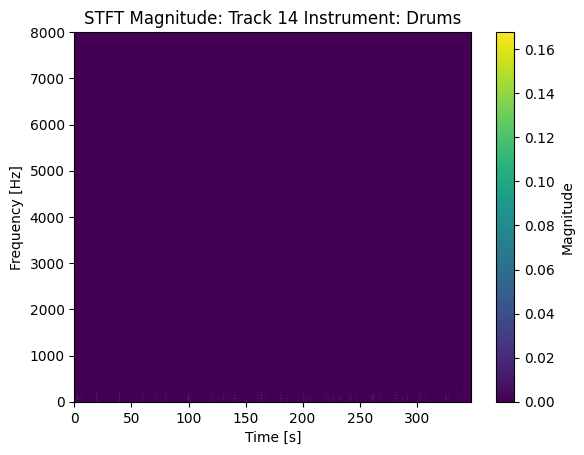

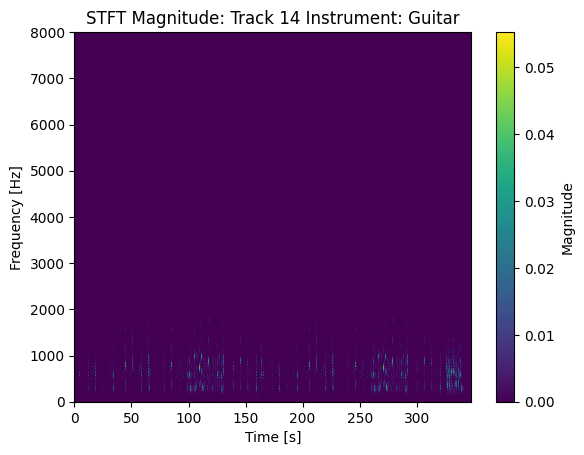

 75%|███████▌  | 15/20 [08:13<02:45, 33.04s/it]

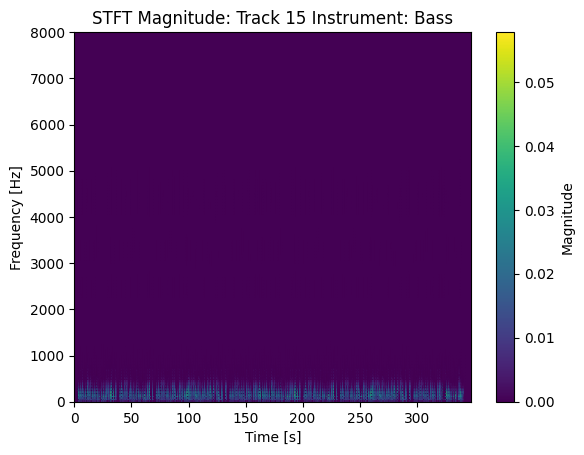

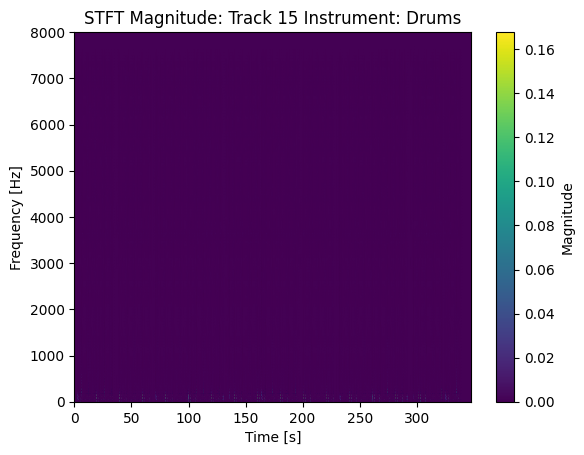

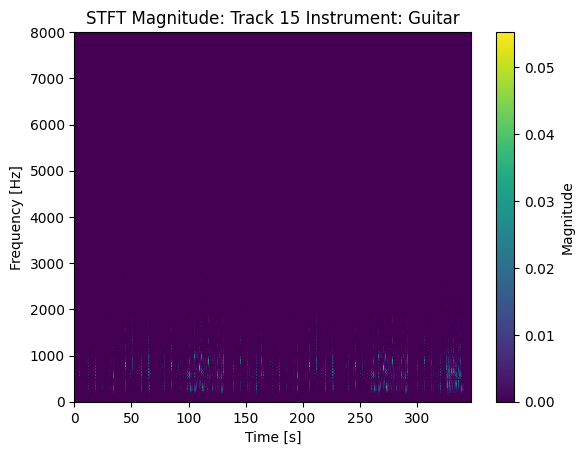

 80%|████████  | 16/20 [08:47<02:12, 33.18s/it]

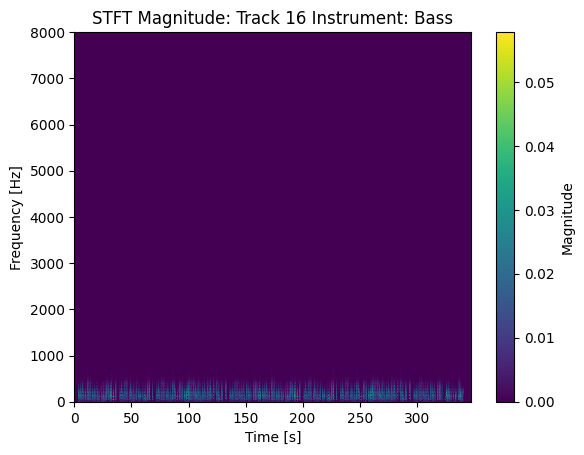

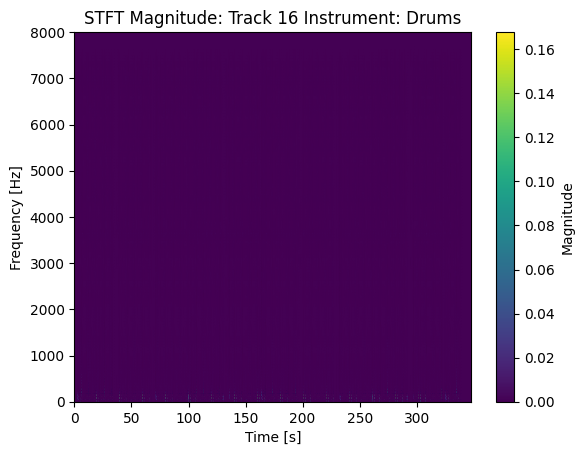

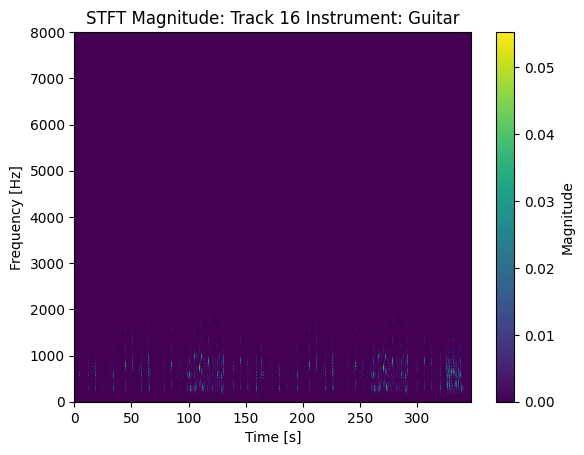

 85%|████████▌ | 17/20 [09:20<01:39, 33.18s/it]

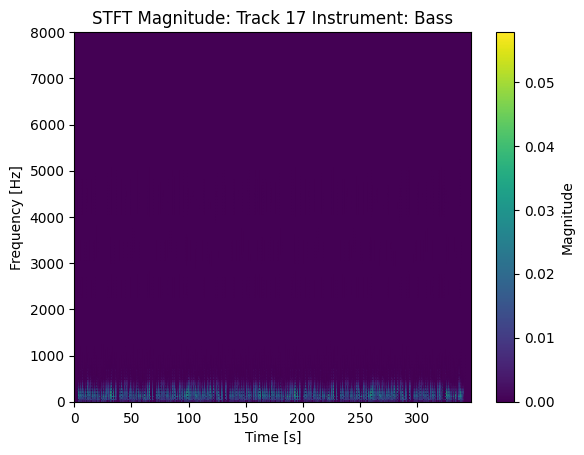

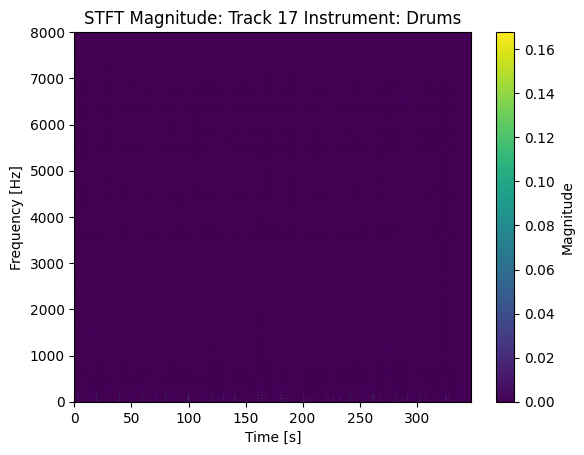

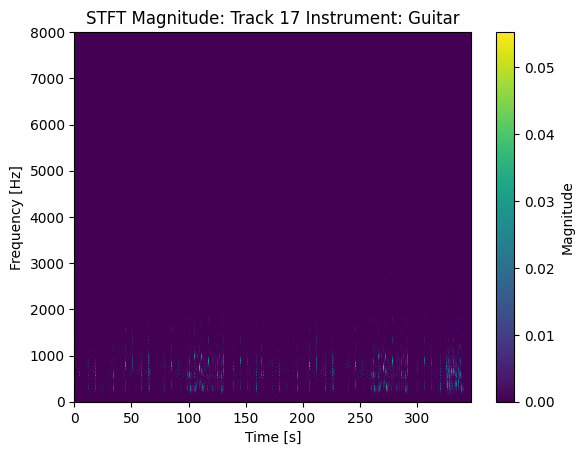

 90%|█████████ | 18/20 [09:53<01:06, 33.14s/it]

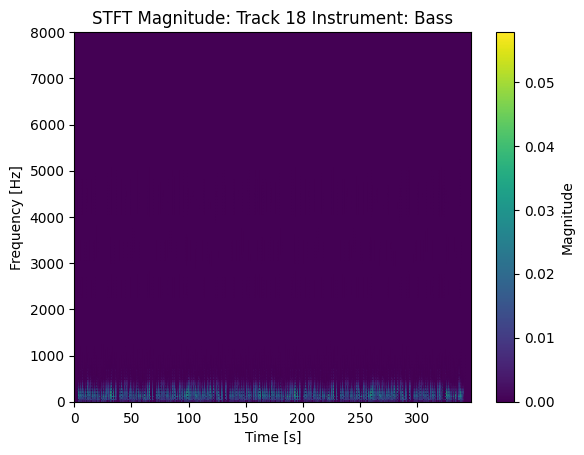

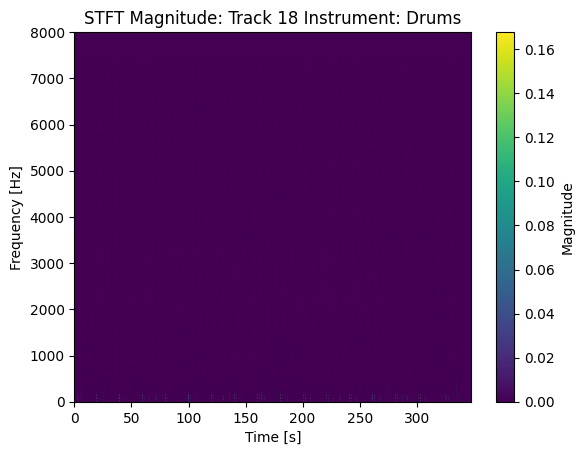

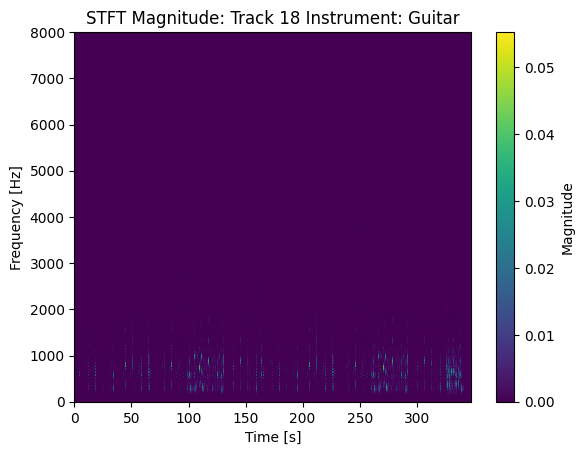

 95%|█████████▌| 19/20 [10:27<00:33, 33.25s/it]

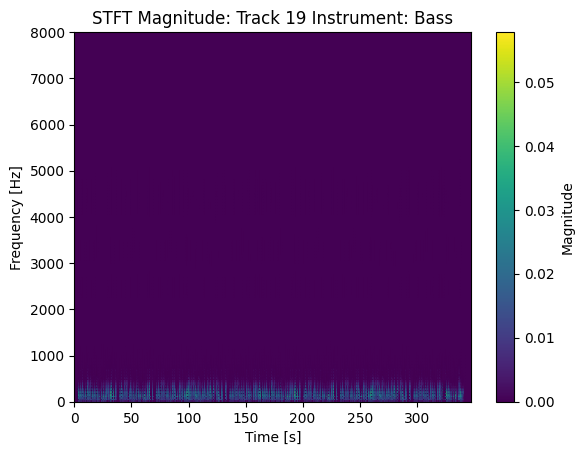

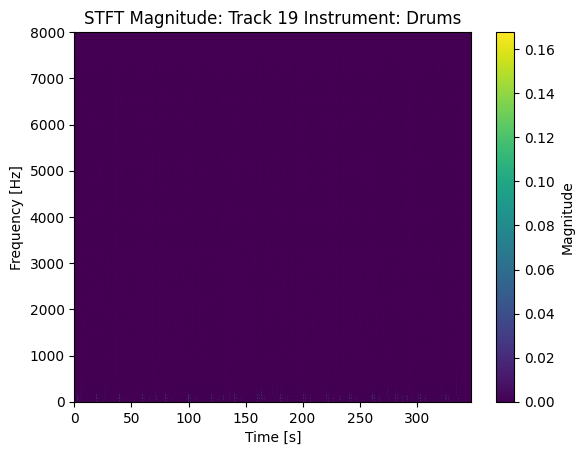

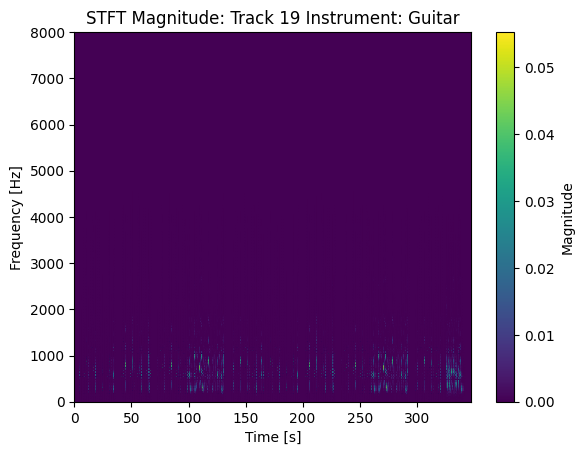

100%|██████████| 20/20 [11:00<00:00, 33.03s/it]


In [4]:
directory = "data/babyslakh_16k"
listdir = os.listdir(directory)
listdir.sort()
tr_dicts = [{}]*len(listdir)
tr_dicts_2 = [{}]*len(listdir)

for i, tr in enumerate(tqdm(listdir)):
    tr_path = os.path.join(directory, tr)
    with open(os.path.join(tr_path, "metadata.yaml")) as meta:
        metadata = yaml.load(meta, Loader=yaml.Loader)
    file_inst = []
    for stem in metadata['stems'].keys():
        file_inst.append([stem + '.wav', metadata['stems'][stem]['inst_class']])
    file_inst = np.array(file_inst)
    file_inst = file_inst[[file_inst[:,0][i] in os.listdir(tr_path + '/stems') for i in range(len(file_inst))]]
    # combine all stems from the same instrument and track using soundfile
    for inst in np.unique(file_inst[:,1]):
        inst_files = file_inst[file_inst[:,1] == inst][:,0]
        inst_files = [os.path.join(tr_path, 'stems', inst_file) for inst_file in inst_files]
        inst_data = np.array([sf.read(inst_file)[0] for inst_file in inst_files])
        inst_data = np.sum(inst_data, axis=0)
        #update the dictionary with the combined data and the instrument name as the key
        tr_dicts[i].update({inst: inst_data})

    for inst in tr_dicts[i].keys():
        if inst in ['Bass', 'Guitar', 'Drums']:
            f, t, Zxx = stft(tr[inst], fs=16000, nperseg=256)
            tr_dicts_2[i].update({inst: np.abs(Zxx)})



# Plot the magnitude of the STFT for each instrument
for i, tr in enumerate(tqdm(tr_dicts_2)):
    for inst in tr.keys():
        plt.pcolormesh(t, f, tr[inst], shading='gouraud')
        plt.colorbar(label='Magnitude')
        plt.title(f'STFT Magnitude: Track {i} Instrument: ' + inst)
        plt.xlabel('Time [s]')
        plt.ylabel('Frequency [Hz]')
        plt.show()

In [ ]:
import yaml
from pydub import AudioSegment
import numpy as np
import wave
import os

old_directory = "babyslakh_16k"
new_directory = "new_babyslack"
try:
    os.mkdir(new_directory)
except:
    pass

for tr in os.listdir(old_directory):
    old_tr = os.path.join(old_directory, tr)
    new_tr = os.path.join(new_directory, tr)
    try:
        os.mkdir(new_tr)
    except:
        pass

    with open(os.path.join(old_tr, "metadata.yaml")) as meta:
        metadata = yaml.load(meta, Loader=yaml.Loader)

    file_inst = []
    for stem in metadata['stems'].keys():
        file_inst.append([stem + '.wav', metadata['stems'][stem]['inst_class']])

    file_inst = np.array(file_inst)
    file_inst = file_inst[[file_inst[:,0][i] in os.listdir(old_tr + '/stems') for i in range(len(file_inst))]]
    
    mix_path = os.path.join(new_tr, 'mix.wav')

    mix = AudioSegment.from_file(os.path.join(old_tr, 'mix.wav'))
    mix.export(mix_path, format='wav')

    unique_inst = np.unique(file_inst[:,1])
    for inst in unique_inst:
        inst_list = []
        inst_path = os.path.join(new_tr, inst + '.wav')
        for i in range(file_inst.shape[0]):
            if file_inst[:,1][i] == inst:
                inst_list.append(file_inst[:,0][i])
        if len(inst_list) > 1:
            sound1 = AudioSegment.from_file(os.path.join(old_tr + '/stems', inst_list[0]))
            for i in range(len(inst_list)-1):
                sound2 = AudioSegment.from_file(os.path.join(old_tr + '/stems', inst_list[i+1]))
                combined = sound1.overlay(sound2)
                sound1 = combined
            combined.export(inst_path, format='wav')
        else:
            sound = AudioSegment.from_file(os.path.join(old_tr + '/stems', inst_list[0]))
            sound.export(inst_path, format='wav')